In [232]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [320]:
import pickle
import string

In [233]:
import pandas as pd
from datetime import datetime
import numpy as np;
import scipy as sp;
import sklearn;
import sys;

from nltk.corpus import stopwords;
import nltk;
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from scipy import linalg

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


# Korean News

## Clean Data

In [404]:
df_c = pd.read_csv("data/naver_news_contacttracing.csv")
df_p = pd.read_csv("data/naver_news_patientspread.csv")
df_c.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
df_p.drop(columns="Unnamed: 0", inplace=True)

In [405]:
df = pd.concat([df_c, df_p])
df.reset_index(drop=True, inplace=True)

In [406]:
len(df)

4286

In [407]:
conservative = df[df.outlet.str.contains("조선일보|중앙일보|동아일보")]
liberal = df[df.outlet.str.contains("한겨레|경향신문")]
len(conservative), len(liberal)

(2953, 1333)

In [408]:
df.outlet.unique()

array(['중앙일보', '중앙일보언론사 선정', '한겨레언론사 선정', '동아일보언론사 선정', '동아일보', '한겨레',
       '디지틀조선일보', '조선일보언론사 선정', '조선일보', '경향신문', '경향신문언론사 선정'],
      dtype=object)

In [409]:
df.keywords.unique()

array(['코로나 역학조사', '확진자 추적'], dtype=object)

In [410]:
# The null ones
print(len(df[df['text'].isnull()]))

# Just drop the null ones. There are only 4
df = df[~df['text'].isnull()]

4


In [411]:
def clean_text(text):
    remove_char = string.punctuation + '…' + '\xa0' + '·' + '\n' + \
        '※' + '‘' + '’' + '\'' + '▲' + '∼' + "△" + "“" + "”" + "▶" + "․" + \
        "▸"
    text = re.sub('http[s]?://\S+', '', text) # Remove http urls
    text = re.sub('\S*@\S*\s?', '', text) # Remove emails
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(remove_char), '', text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub('\'', '', text)
    text = re.sub(r'Copyright .* rights reserved', '', text) # Remove "Copyright all rights reserved"
    return text


In [412]:
df['text_clean'] = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [417]:
df.to_pickle("korean_news_raw.pkl")

## Preprocess

### Morphemes

In [123]:
# Break text into its morphemes
# FYI this takes forever

from konlpy.tag import Okt  
okt=Okt()  
texts_ko = [okt.morphs(doc) for doc in df['text_clean']]
# print(texts_ko[0])

In [403]:
type(texts_ko)

list

In [153]:
# Save this to file
with open('texts_ko_morphemes.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(texts_ko, filehandle)

### Tokenize

In [418]:
df = pd.read_pickle("korean_news_raw.pkl")

In [419]:
# Import the Korean morphemes
with open('texts_ko_morphemes.data', 'rb') as filehandle:
    # read the data as binary data stream
    morphemes = pickle.load(filehandle)

In [420]:
# Tokenize the morphemes
from itertools import chain

ko = nltk.Text(morphemes)
ko_list = list(chain.from_iterable(ko.tokens))
len(ko_list), len(set(ko_list))

(2546066, 35924)

In [421]:
# Import Korean stop words from https://github.com/stopwords-iso/stopwords-ko
import json
with open('korean_stopwords.json') as f:
  stopwords = json.load(f)

# Add some extra words
stopwords.extend(['에서', '으로', '이다', '는', '한', '은', '씨', 'A', '서', '다', '했다', '하는', 'ㆍ'])

In [422]:
ko_list.count('코로나') 

5139

In [423]:
df['text_tokenized'] = texts_ko

In [424]:
# Remove stopwords from tokens
# This takes a while
# but not TOO long of a while
# It's like an okay kind of while I guess
df['text_tokenized'] = df['text_tokenized'].apply(lambda x: [a for a in x if a not in stopwords])


In [426]:
df['date'] = pd.to_datetime(df.date, errors="coerce")
print(len(df))

4282


In [427]:
df.head()

,outlet,date,keywords,title,url,text,text_clean,text_tokenized
0,중앙일보,2020-01-06,코로나 역학조사,中 폐렴 59명으로 늘고 홍콩·싱가포르 의심환자…출장가도 될까,https://news.joins.com/article/olink/23269722,중국에서 원인을 알 수 없는 폐렴에 걸린 환자가 며칠 새 크게 불어나고 있다. 중국...,중국에서 원인을 알 수 없는 폐렴에 걸린 환자가 며칠 새 크게 불어나고 있다 중국 ...,"[중국, 원인, 알, 수, 없는, 폐렴, 걸린, 환자, 며칠, 새, 크게, 불어나고..."
1,중앙일보언론사 선정,2020-01-08,코로나 역학조사,'中 원인불명 폐렴' 국내 첫 의심환자 발생…36세 중국여성,https://news.joins.com/article/olink/23271730,우한 화난 수산시장. [신경보=연합뉴스] 중국에서 최근 유행 중인 원...,우한 화난 수산시장 중국에서 최근 유행 중인 원인불명 폐렴 환자와 ...,"[우한, 화난, 수산시장, 중국, 최근, 유행, 중인, 원인, 불명, 폐렴, 환자,..."
2,한겨레언론사 선정,2020-01-08,코로나 역학조사,‘원인불명 중국 폐렴’ 의심환자 국내 첫 발생,http://www.hani.co.kr/arti/society/health/9236...,"중국 후베이성 우한을 다녀온 뒤 폐렴에 걸린 환자가 한명 발생해, 보건당국이 격리 ...",여성은 우한 방문 당시 폐렴 환자가 대거 발생한 화난 해산물 시장을 방문한 적은 ...,"[여성, 우한, 방문, 당시, 폐렴, 환자, 대거, 발생, 화난, 해산물, 시장, ..."
3,중앙일보언론사 선정,2020-01-08,코로나 역학조사,"국내 '中원인불명 폐렴' 의심 36세 여성…""접촉자 증상은 없어""",https://news.joins.com/article/olink/23271933,중국에서 원인을 알수 없는 폐렴이 확산하면서 우리나라 보건당국도 검역 관리 강화에 ...,중국에서 원인을 알수 없는 폐렴이 확산하면서 우리나라 보건당국도 검역 관리 강화에 ...,"[중국, 원인, 알수, 없는, 폐렴, 확산, 우리나라, 보건, 당, 국도, 검역, ..."
4,동아일보언론사 선정,2020-01-09,코로나 역학조사,"원인불명 폐렴 증상 中 여성, 상태 호전…“접촉자는 29명”",http://www.donga.com/news/article/all/20200109...,지난달 우한 다녀온 30대 여성\n사진=뉴시스중국 후베이(湖北)성 우한(武漢)시에서...,지난달 우한 다녀온 여성사진뉴시스중국 후베이湖北성 우한武漢시에서 집단 발생한 원인...,"[지난달, 우한, 다녀온, 여성, 사진, 뉴시스, 중국, 후베이, 湖北, 성, 우한..."


In [428]:
df.to_pickle("korean_proc.pkl")

## Topic Modeling

In [254]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [255]:
df = pd.read_pickle("korean_proc.pkl")
df.reset_index(inplace=True, drop=True)


In [256]:
conservative = df[df.outlet.str.contains("조선일보|중앙일보|동아일보")]
liberal = df[df.outlet.str.contains("한겨레|경향신문")]
len(conservative), len(liberal)

(2949, 1333)

In [257]:
def nmf_topic_modeling(df, num_topics, num_top_words):
    documents = [' '.join(a) for a in df.text_tokenized]
    
    vectorizer = TfidfVectorizer(min_df=1, lowercase=False)
    vectors = vectorizer.fit_transform(documents)
    clf = NMF(n_components=num_topics, random_state=1, init='nndsvd')
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)

In [205]:
nmf_topic_modeling(conservative, 6, 15)

['환자 우한 중국 폐렴 감염 병원 국내 신종 관리 하고 코로나 지역 본부 감염증 질병',
 '입국 외국인 모든 격리 대상 비자 경우 자가 지정 경유 중국 이내 가능 이탈리아 발급',
 '클럽 이태원 감염 진자 서울 관련 등교 방문 방역 노래방 인천 학원 용산구 집단 주점',
 '신천지 교회 대구 신도 교인 예배 명단 대구시 과천 참석 조사 경기도 수사 진자 지역',
 '추천 병사 남북 전선 용서 미안해 하겠다니이 분대 푼돈 끌려가 삐라 수리온 오세요 벌겠다고 매단',
 '판정 진자 확진 병원 받았다 지난 검사 격리 직원 접촉 됐다 인천 받은 추가 콜센터']

In [206]:
nmf_topic_modeling(liberal, 6, 15)

['판정 확진 진자 병원 지난 검사 여성 받았다 격리 조사 진료 양성 증상 울산 방문',
 '환자 감염 신종 중국 병원 본부 코로나바이러스 방역 의료 관리 국내 입국 우한 사회 격리',
 '신천지 교회 신도 교인 예배 대구 명단 대구시 참석 과천 조사 경기도 진자 관련 경찰',
 '클럽 이태원 감염 학원 등교 서울 인천 방문 강사 방역 방문자 학생 수업 노래방 관련',
 '부산 부산시 진자 온천 경남 부산진구 동래구 교회 판정 격리 감염 도착 환자 해운대구 지난달',
 '콜센터 인천 직원 구로구 서울 부천 진자 판정 물류 쿠팡 근무 센터 거주 빌딩 감염']

In [207]:
# This is liberal + conservative (all)
nmf_topic_modeling(df, 6, 15)

['판정 진자 확진 지난 병원 받았다 검사 격리 여성 직원 부산 양성 됐다 인천 접촉',
 '입국 외국인 모든 격리 대상 비자 자가 중국 경우 경유 지정 이탈리아 이내 가능 한국',
 '클럽 이태원 감염 진자 서울 등교 관련 인천 방역 방문 학원 노래방 집단 방문자 용산구',
 '신천지 교회 신도 대구 교인 예배 명단 대구시 과천 참석 조사 경기도 진자 관련 수사',
 '환자 감염 우한 중국 병원 폐렴 신종 국내 관리 본부 코로나 의료 지역 사회 질병',
 '추천 병사 전선 용서 수리온 삐라 미안해 매단 끌려가 하겠다니이 오세요 푼돈 벌겠다고 폭행 분대']

In [212]:
def lda_topic_modeling(df, num_topics, num_top_words):
    documents = [' '.join(a) for a in df.text_tokenized]
    
    vectorizer = CountVectorizer(analyzer='word', min_df=3, max_features=5000)
    vectors = vectorizer.fit_transform(documents)

    clf = LatentDirichletAllocation(n_components=num_topics, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
    
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)


In [213]:
lda_topic_modeling(conservative, 6, 15)

['판정 진자 확진 병원 검사 지난 받았다 격리 접촉 됐다 조사 하고 감염 환자 방문',
 '입국 격리 외국인 모든 대상 경우 자가 방문 국민 중국 시설 한국 비자 검사 지정',
 '신천지 교회 진자 감염 우한 신종 중국 조사 코로나 확진 대구 하고 예배 신도 교인',
 '추천 환자 확진 연락 사무소 뉴스 폭파 진자 베스트 하셨습니다 추가 감염 기사 격리 기자',
 '감염 환자 진자 클럽 방역 발생 관련 이태원 접촉 하고 서울 검사 지역 조사 집단',
 '하고 방역 확산 감염 정부 대응 진자 한국 코로나 마스크 상황 중국 한다 추적 기자']

In [214]:
lda_topic_modeling(liberal, 6, 15)

['진자 병원 교회 감염 환자 신천지 조사 확진 대구 검사 판정 하고 격리 부산 발생',
 '확진 판정 검사 진자 접촉 격리 조사 지난 방문 하고 증상 역학 됐다 확인 환자',
 '진자 감염 클럽 이태원 확진 판정 방역 서울 직원 지난 하고 인천 발생 콜센터 학원',
 '신천지 감염병 역학 경찰 조사 수사 명단 고발 위반 사실 검찰 허위 사건 하고 거부',
 '감염 진자 하고 방역 환자 중국 지역 정부 확산 의료 있는 신종 사람 사회 대응',
 '사회 하고 한다 정보 감염 기술 방역 한국 시민 정부 사람 추적 대한 시스템 있는']

In [215]:
lda_topic_modeling(df, 6, 15)

['클럽 이태원 방역 등교 하고 감염 학생 서울 학원 시설 관련 학교 센터 진자 물류',
 '입국 격리 외국인 모든 대상 경우 자가 방문 국민 중국 시설 한국 비자 검사 지정',
 '추천 뉴스 연락 사무소 환자 폭파 베스트 기사 하셨습니다 추가 병사 공개 확진 위해 에도',
 '진자 확진 판정 환자 감염 검사 병원 접촉 조사 지난 격리 됐다 하고 확인 발생',
 '감염 하고 환자 방역 진자 정부 중국 사회 코로나 사람 확산 한다 신종 바이러스 지역',
 '신천지 교회 대구 조사 신도 교인 예배 대구시 하고 명단 진자 관련 역학 경찰 경기도']

## Data Exploration

In [263]:
import itertools

In [258]:
df = pd.read_pickle("korean_proc.pkl")
df.reset_index(inplace=True, drop=True)
conservative = df[df.outlet.str.contains("조선일보|중앙일보|동아일보")]
liberal = df[df.outlet.str.contains("한겨레|경향신문")]

In [264]:
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, list):
            list_flatten(i, a)
        else:
            if (len(i) != 1): a.append(i)
    return a

### Frequency

In [246]:
lib_freq = list_flatten(liberal.text_tokenized.values)
lib_dist = nltk.FreqDist(lib_freq)

In [247]:
top_frequent = []
for keys in lib_dist.most_common(50):
    print(keys)
    a,b = keys
    top_frequent.append(a)

' '.join([item for item in top_frequent if item not in stopwords])

('진자', 5158)
('감염', 3846)
('하고', 3075)
('확진', 2731)
('환자', 2612)
('판정', 2608)
('검사', 2535)
('조사', 2496)
('병원', 2144)
('격리', 2067)
('방역', 2065)
('지난', 2005)
('접촉', 1947)
('역학', 1879)
('발생', 1626)
('지역', 1623)
('신천지', 1608)
('밝혔다', 1556)
('됐다', 1506)
('확인', 1455)
('증상', 1339)
('방문', 1308)
('교회', 1289)
('있는', 1228)
('관리', 1200)
('대구', 1197)
('의료', 1129)
('관련', 1098)
('당국', 1086)
('추가', 1061)
('서울', 1041)
('자가', 1009)
('대한', 985)
('받았다', 980)
('사회', 980)
('본부', 970)
('확산', 956)
('결과', 925)
('정부', 925)
('오후', 914)
('파악', 876)
('중국', 869)
('현재', 865)
('진료', 865)
('받은', 861)
('사람', 858)
('직원', 850)
('대해', 833)
('시설', 829)
('기자', 812)


'진자 감염 하고 확진 환자 판정 검사 조사 병원 격리 방역 지난 접촉 역학 발생 지역 신천지 밝혔다 됐다 확인 증상 방문 교회 있는 관리 대구 의료 관련 당국 추가 서울 자가 대한 받았다 사회 본부 확산 결과 정부 오후 파악 중국 현재 진료 받은 사람 직원 대해 시설 기자'

In [248]:
con_freq = list_flatten(conservative.text_tokenized.values)
con_dist = nltk.FreqDist(con_freq)

In [222]:
top_frequent = []
for keys in con_dist.most_common(50):
    print(keys)
    a,b = keys
    top_frequent.append(a)
    
' '.join([item for item in top_frequent if item not in stopwords])

('입국', 30080)
('격리', 20112)
('외국인', 16207)
('모든', 13536)
('진자', 12015)
('대상', 11614)
('검사', 10161)
('방문', 9384)
('감염', 9210)
('자가', 8659)
('환자', 8633)
('경우', 8601)
('하고', 7534)
('지역', 7332)
('중국', 7303)
('시설', 6720)
('국민', 6717)
('한국', 6622)
('확진', 6532)
('판정', 6477)
('확인', 5962)
('병원', 5699)
('발생', 5496)
('지정', 5266)
('조사', 5211)
('비자', 5177)
('국가', 5045)
('방역', 4981)
('관련', 4820)
('거주', 4702)
('코로나', 4638)
('접촉', 4574)
('신종', 4164)
('조치', 4080)
('또는', 4062)
('음성', 4019)
('증상', 3987)
('가능', 3952)
('있는', 3900)
('지난', 3825)
('금지', 3797)
('경유', 3793)
('이내', 3777)
('이탈리아', 3691)
('의료', 3652)
('당국', 3636)
('역학', 3592)
('가족', 3583)
('됐다', 3466)
('이란', 3398)


'입국 격리 외국인 모든 진자 대상 검사 방문 감염 자가 환자 경우 하고 지역 중국 시설 국민 한국 확진 판정 확인 병원 발생 지정 조사 비자 국가 방역 관련 거주 코로나 접촉 신종 조치 또는 음성 증상 가능 있는 지난 금지 경유 이내 이탈리아 의료 당국 역학 가족 됐다 이란'

### Word Clouds

In [249]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [269]:
con = ' '.join(list_flatten(conservative.text_tokenized.values))

In [282]:
# Having issues bc of Korean font problems... 

# data = con_dist.most_common(50)

# wordcloud = WordCloud(
#     font_path= '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
#     relative_scaling=0.4,
# #     stopwords=stop_words,
#     background_color='white',
# ).generate_from_frequencies( dict(data) )


# plt.figure( figsize=(12, 6) )
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

# American News

## Clean Data (merge american news datasets)

In [465]:
cnn = pd.read_csv("data/cnn.csv")
fox = pd.read_csv("data/fox.csv")
nyt = pd.read_csv("data/nyt.csv")
wp = pd.read_csv("data/washingtonpost.csv")
usa = pd.read_csv("data/usatoday.csv")

dailycaller = pd.read_csv("data/dailycaller.csv")
breitbart = pd.read_csv("data/breitbart.csv")


In [466]:
cnn["source"] = "cnn"
fox["source"] = "fox"
nyt["source"] = "nyt"
dailycaller["source"] = "dailycaller"
breitbart["source"] = "breitbart"
nyt.rename(columns={"body": "text"}, inplace=True)
wp["source"] = "washington post"
usa["source"] = "usa today"
usa.drop(columns="Unnamed: 0.1", inplace=True)


In [467]:
wp.columns, usa.columns, fox.columns, nyt.columns, cnn.columns, dailycaller.columns, breitbart.columns

(Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['title', 'date', 'url', 'text', 'source'], dtype='object'))

In [468]:
df = pd.concat([cnn, fox, nyt, wp, usa, dailycaller, breitbart])
df["keyword"] = "contact tracing"
df.drop(columns="Unnamed: 0", inplace=True)
df.reset_index(drop=True, inplace=True)

In [469]:
# These are all the null ones, usually due to being video, radio, or interactive files. We will drop these
nullvals = df[df['text'].isnull()]
print(len(nullvals))

df = df[df['text'].notna()]
print(len(df))

27
3623


In [470]:
# Fix dates with weird formats
df['date2'] = pd.to_datetime(df.date, errors="coerce")
a = df[df['date2'].isnull()].date.str.extract("(.*)T", expand=False)
df.loc[a.index, "date2"] = a.values

df['date'] = pd.to_datetime(df['date2'], utc=True).dt.date
df.drop(columns="date2", inplace=True)

/Users/yenniejun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [471]:
len(df[df['date'].isnull()]), len(df[df['text'].isnull()])

(0, 0)

In [472]:
df.sort_values(by="date", inplace=True)

# Drop the things before 2020-01-01
df = df.loc[df.date > pd.to_datetime("2020-01-01").date()]
df.reset_index(inplace=True, drop=True)

In [475]:
df.to_pickle("us_news_raw.pkl")

## Preprocess Data (lemmatize, stem)

In [480]:
df = pd.read_pickle("us_news_raw.pkl")
df.reset_index(inplace=True, drop=True)

In [483]:
# Number of articles vs. Number of articles that mention "contact tracing"
len(df), len(df[df.text.str.contains("contact tracing|contact-tracing")])

(3492, 2153)

In [484]:
# Drop all the articles that do not explicitly mention contact tracing
df = df[df.text.str.contains("contact tracing|contact-tracing")]

In [485]:
import nltk
nltk.download('wordnet')

np.random.seed(2018)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yenniejun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [338]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(WordNetLemmatizer().lemmatize(token, pos='v'))
            result.append(lemmatize_stemming(token))
    return result

In [319]:
df['text_proc'] = df['text'].map(preprocess)
df['text_proc'] = df['text_proc'].apply(lambda a: ' '.join(a))

df.head()

,title,date,url,text,source,keyword,text_proc
0,China identifies new strain of coronavirus as ...,2020-01-09,https://www.washingtonpost.com/world/asia_paci...,BEIJING — Chinese researchers investigating th...,washington post,contact tracing,beij chines research investig caus mysteri pne...
1,Airport screenings for the Wuhan coronavirus i...,2020-01-22,https://www.cnn.com/travel/article/coronavirus...,Airports around the world are increasing healt...,cnn,contact tracing,airport world increas health screen implement ...
2,China restricts travel for 35 million people t...,2020-01-24,https://www.washingtonpost.com/health/china-re...,Beijing — China locked down more than 35 milli...,washington post,contact tracing,beij china lock million peopl increas urgent e...
3,Coronavirus claims 15 more lives in China; fir...,2020-01-24,https://www.washingtonpost.com/world/coronavir...,BEIJING — France confirmed three cases of coro...,washington post,contact tracing,beij franc confirm case coronavirus friday mar...
4,January 26 coronavirus news,2020-01-26,https://www.cnn.com/asia/live-news/coronavirus...,Our live coverage has ended. Click here to fol...,cnn,contact tracing,live coverag end click follow latest updat con...


In [321]:
df.to_pickle("us_proc.pkl")

## Explore Data

In [437]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [438]:
df = pd.read_pickle("us_proc.pkl")
df.reset_index(inplace=True, drop=True)

In [439]:
df.source.unique()

array(['washington post', 'cnn', 'fox', 'nyt', 'dailycaller', 'usa today',
       'breitbart'], dtype=object)

In [440]:
# Articles that specifically mention contact tracing
len(df[df['text'].str.contains("contact tracing|contact-tracing")]), len(df)

(2153, 2153)

In [448]:
liberal = df[df.source.str.contains("nyt|washington post|cnn")].reset_index()

In [449]:
conservative = df[df.source.str.contains("fox|dailycaller|breitbart")].reset_index()

In [450]:
len(liberal), len(conservative)

(1851, 229)

In [451]:
liberal[:10].title.values

array(['China identifies new strain of coronavirus as source of pneumonia outbreak',
       'Airport screenings for the Wuhan coronavirus increase around the world',
       'China restricts travel for 35 million people to halt spread of deadly virus',
       'Coronavirus claims 15 more lives in China; first three cases reported in Europe; first case reported in Australia; 2 cases confirmed in U.S.',
       'January 26 coronavirus news', 'January 27 coronavirus news',
       'January 28 coronavirus news',
       "China's national women's soccer team quarantined in Brisbane hotel amid coronavirus fears",
       'How deadly is coronavirus, and can it be contained?',
       'Can this virus be contained? Probably not.'], dtype=object)

In [452]:
conservative[:10].title.values

array(["Coronavirus outbreak in US may depend on this: 'We just don't know yet' says infectious disease doc",
       'How past outbreaks shaped coronavirus response in US',
       'CDC director says coronavirus threat in US remains low, but warns there will be new cases',
       "HHS Secretary Alex Azar gives coronavirus update on 'Fox News Sunday'",
       "Dr. Anthony Fauci: Coronavirus cases in US are becoming ‘community spread' and could be more prevalent",
       'HHS Secretary Azar says new coronavirus case appears in Chicago',
       "Dr. Anthony Fauci: Coronavirus cases in US are becoming ‘community spread' and could be more prevalent",
       "HHS Secretary Alex Azar gives coronavirus update on 'Fox News Sunday'",
       'HHS Secretary Azar says new coronavirus case appears in Chicago',
       'HHS Secretary Azar says new coronavirus case appears in Chicago'],
      dtype=object)

### Frequent Words

In [362]:
# Frequent words
def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, list):
            list_flatten(i, a)
        else:
            if (len(i) != 1): a.append(i)
    return a

In [363]:
def find_top_frequent_words(documents, top_n):
    dist = nltk.FreqDist(documents)
    top_frequent = []
    for keys in dist.most_common(top_n):
#         print(keys)
        a,b = keys
        top_frequent.append(keys)
    return top_frequent

In [364]:
con = [a.split() for a in conservative.text_proc.values]
con = list_flatten(con)
find_top_frequent_words(con, 50)

[('say', 1605),
 ('peopl', 1518),
 ('coronavirus', 1335),
 ('state', 1315),
 ('go', 1145),
 ('think', 1049),
 ('test', 1038),
 ('know', 1017),
 ('presid', 900),
 ('health', 857),
 ('news', 769),
 ('case', 720),
 ('like', 714),
 ('right', 703),
 ('countri', 645),
 ('time', 637),
 ('contact', 628),
 ('come', 610),
 ('need', 589),
 ('reopen', 567),
 ('work', 565),
 ('want', 565),
 ('virus', 560),
 ('trump', 560),
 ('trace', 523),
 ('covid', 515),
 ('wallac', 497),
 ('week', 493),
 ('thing', 483),
 ('look', 474),
 ('home', 442),
 ('report', 435),
 ('governor', 428),
 ('public', 426),
 ('busi', 412),
 ('american', 408),
 ('begin', 403),
 ('number', 394),
 ('infect', 388),
 ('tell', 385),
 ('spread', 371),
 ('biden', 353),
 ('york', 337),
 ('hous', 335),
 ('economi', 330),
 ('talk', 327),
 ('thank', 324),
 ('good', 320),
 ('democrat', 317),
 ('clip', 316)]

In [365]:
lib = [a.split() for a in liberal.text_proc.values]
lib = list_flatten(lib)
find_top_frequent_words(lib, 50)

[('say', 46981),
 ('coronavirus', 28907),
 ('state', 23321),
 ('test', 22496),
 ('health', 22473),
 ('peopl', 22470),
 ('case', 22026),
 ('virus', 12977),
 ('countri', 12946),
 ('death', 11644),
 ('report', 11575),
 ('covid', 10932),
 ('week', 10396),
 ('trump', 10110),
 ('infect', 9702),
 ('reopen', 9629),
 ('govern', 9373),
 ('public', 9302),
 ('pandem', 9102),
 ('need', 8998),
 ('work', 8868),
 ('number', 8865),
 ('offici', 8756),
 ('accord', 8737),
 ('home', 8474),
 ('time', 8426),
 ('presid', 8000),
 ('like', 7870),
 ('includ', 7535),
 ('spread', 7394),
 ('citi', 7343),
 ('hospit', 7304),
 ('nation', 7232),
 ('contact', 7044),
 ('go', 6761),
 ('mask', 6624),
 ('come', 6515),
 ('tell', 6402),
 ('know', 6099),
 ('diseas', 6011),
 ('busi', 5990),
 ('social', 5976),
 ('outbreak', 5970),
 ('news', 5941),
 ('posit', 5922),
 ('patient', 5902),
 ('care', 5751),
 ('world', 5723),
 ('unit', 5599),
 ('year', 5572)]

### Word Clouds

In [ ]:
con = ' '.join(conservative.text_proc.values)

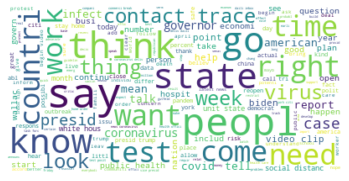

In [396]:
wordcloud = WordCloud(max_font_size=50, background_color="white").generate(con)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [394]:
lib = ' '.join(liberal.text_proc.values)

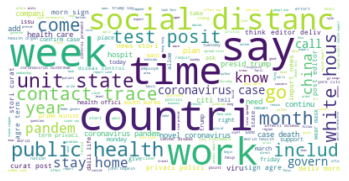

In [397]:
wordcloud = WordCloud(max_font_size=50, background_color="white").generate(lib)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Modeling

In [350]:
df = pd.read_pickle("us_proc.pkl")
df.reset_index(inplace=True, drop=True)


### LDA

In [351]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [352]:
def lda_topic_modeling(df, num_topics, num_top_words):
    documents = [''.join(a) for a in df.text_proc]
    
    vectorizer = CountVectorizer(analyzer='word', min_df=3, stop_words='english', token_pattern='[a-zA-Z0-9]{3,}', max_features=5000)
    vectors = vectorizer.fit_transform(documents)

    clf = LatentDirichletAllocation(n_components=num_topics, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
    
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)


In [379]:
lda_topic_modeling(conservative, num_topics = 6, num_top_words = 15)

['peopl know think say coronavirus state like time come test news presid infect health virus',
 'state say peopl know think test presid coronavirus come like right countri health need look',
 'coronavirus say test health state peopl contact trace case news covid virus reopen report infect',
 'know say peopl think biden maccallum right thank look democrat come home state news wallac',
 'think peopl presid know state say right like want wallac trump time come thing countri',
 'state coronavirus york citi say blasio busi reopen feder news think govern work economi open']

In [380]:
lda_topic_modeling(liberal, num_topics = 6, num_top_words = 15)

['coronavirus say case health travel china peopl state countri test accord confirm virus outbreak govern',
 'case countri coronavirus say virus death infect peopl health lockdown world pandem govern covid report',
 'say state coronavirus test health case peopl covid accord reopen report death week trump presid',
 'say trump state test peopl coronavirus health need work know pandem presid public compani contact',
 'peopl say coronavirus symptom test percent mask virus seat infect like spread state health day',
 'say test state health case peopl reopen coronavirus covid contact home counti hospit school sign']

In [378]:
lda_topic_modeling(df, num_topics = 6, num_top_words = 15)

['school say student test player sport team univers campus posit leagu play plan colleg season',
 'case countri coronavirus say death virus infect peopl health govern lockdown pandem world covid test',
 'coronavirus say case health china peopl travel state countri test virus accord confirm report outbreak',
 'test peopl say state trump know health coronavirus need contact work presid public think trace',
 'peopl say test coronavirus symptom percent virus infect mask spread health state like seat public',
 'say state coronavirus health test case peopl covid reopen report death week accord number citi']

In [356]:
len(liberal), len(liberal[liberal.text.str.contains("contact tracing")])

(1851, 1695)

### NMF

In [358]:
def nmf_topic_modeling(df, num_topics, num_top_words):
    documents = [''.join(a) for a in df.text_proc]
    
    vectorizer = TfidfVectorizer(min_df=1, lowercase=False)
    vectors = vectorizer.fit_transform(documents)
    clf = NMF(n_components=num_topics, random_state=1, init='nndsvd')
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)

In [375]:
nmf_topic_modeling(conservative, num_topics = 6, num_top_words = 15)

['test health peopl isol infect coronavirus need covid contact million virus care say posit home',
 'wallac think go presid know right biden peopl want like clip thing video thank look',
 'googl appl app user privaci tech data contact technolog trace track bluetooth devic phone giant',
 'protest floyd citi blasio georg mayor peopl york gather virus death atlanta adalja mask coronavirus',
 'state reopen coronavirus say busi trump order governor economi cuomo plan phase news open case',
 'case coronavirus say asymptomat fauci symptom rare azar health offici infect china outbreak spread diseas']

In [376]:
nmf_topic_modeling(liberal, num_topics = 6, num_top_words = 15)

['say case coronavirus countri death health report accord china virus total lockdown minist travel number',
 'seat symptom peopl percent exercis coronavirus surfac say mask touch fever studi wear spread day',
 'trump say presid test state hous white administr reopen biden governor democrat fauci coronavirus republican',
 'test peopl infect coronavirus virus case health need countri stori covid sign curat editor state',
 'googl appl compani data technolog app tech smartphon user privaci bluetooth contact health track phone',
 'say state maryland virginia counti reopen citi health hogan test district case peopl region home']

In [377]:
nmf_topic_modeling(df, num_topics = 6, num_top_words = 15)

['trump presid hous say white state biden administr test democrat governor coronavirus reopen republican fauci',
 'seat symptom peopl percent exercis surfac mask coronavirus touch fever studi wear say spread day',
 'appl googl app technolog data compani user tech privaci smartphon contact bluetooth health trace track',
 'say case coronavirus countri death china health report virus accord lockdown travel minist infect world',
 'test peopl infect coronavirus need virus health case covid state stori sign curat editor contact',
 'say state reopen counti health maryland virginia citi case test order peopl coronavirus busi governor']

## SVD


In [293]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)


CPU times: user 8.59 s, sys: 639 ms, total: 9.22 s
Wall time: 6.33 s


In [294]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [295]:
show_topics(Vh[:10])


['exosuit ufos scuba misappropriated immerse nonindividualization vibrancy treatise',
 'cases coronavirus china confirmed health outbreak novel case',
 'said state according trump today cnn cases announced',
 'state tested case public testing symptoms contact said',
 'health life daily trump travel business president coronavirus',
 'cases new states united tested positive president italy',
 'travel president testing covid 19 vaccine tuesday reopening',
 'health wednesday tuesday state states thursday covid 19',
 'state travel city announced wuhan restrictions wednesday health',
 'thursday friday people positive hall tested town saturday']